# Q1: 量化交易怎么赚钱？

本章通过一个具体的例子——定投沪深300ETF——带你一步步建立量化交易的基础直觉。

你将经历三个阶段：
- **v0.1 定投策略**：最简单的量化策略，理解回测和 Beta
- **v0.2 均线择时**：加入判断条件，尝试获取 Alpha
- **v0.3 参数优化**：寻找最优参数，掉入过拟合陷阱

### 前置条件

- 已完成环境配置（见 `setup/env-setup-spec.md`）
- 已在 TRAE 中打开课程文件夹

### 操作方式

每个步骤你需要：
1. 阅读下面的说明，了解这一步做什么、为什么做
2. 打开对应的 spec 文件，将全部内容复制到 TRAE 的 AI 助手中
3. 当弹出沙箱权限请求时，选择「允许」
4. 观察 AI 生成的代码和运行结果
5. 回到这里，阅读结果解读，理解背后的含义

如果任何步骤出了问题，把 TRAE 中显示的错误信息完整复制给 AI，让它帮你排查。

下面每个步骤的「参考代码」是我们运行 spec 后得到的标准产出，供你对照或直接运行查看效果。

---

## Step 1: 获取数据

一切量化分析的起点是**数据**。我们需要获取沪深300ETF的历史价格数据，这是后续所有策略回测的基础。

沪深300ETF（代码 510300）跟踪沪深300指数，代表A股市场中最大的300只股票的整体表现。

👉 **打开 `specs/spec-01-get-data.md`，将全部内容复制到 TRAE 的 AI 助手中。**

               Close      High       Low      Open     Volume
Date                                                         
2021-01-04  4.762662  4.791235  4.696589  4.714447  506705639
2021-01-05  4.851058  4.861773  4.736768  4.751055  622830794
2021-01-06  4.894809  4.923382  4.836772  4.863558  374945107
2021-01-07  4.999278  5.000170  4.895702  4.901953  470659227
2021-01-08  4.974277  5.027850  4.927847  5.007314  697564767

数据范围: 2021-01-04 到 2026-02-25
数据总行数: 1243


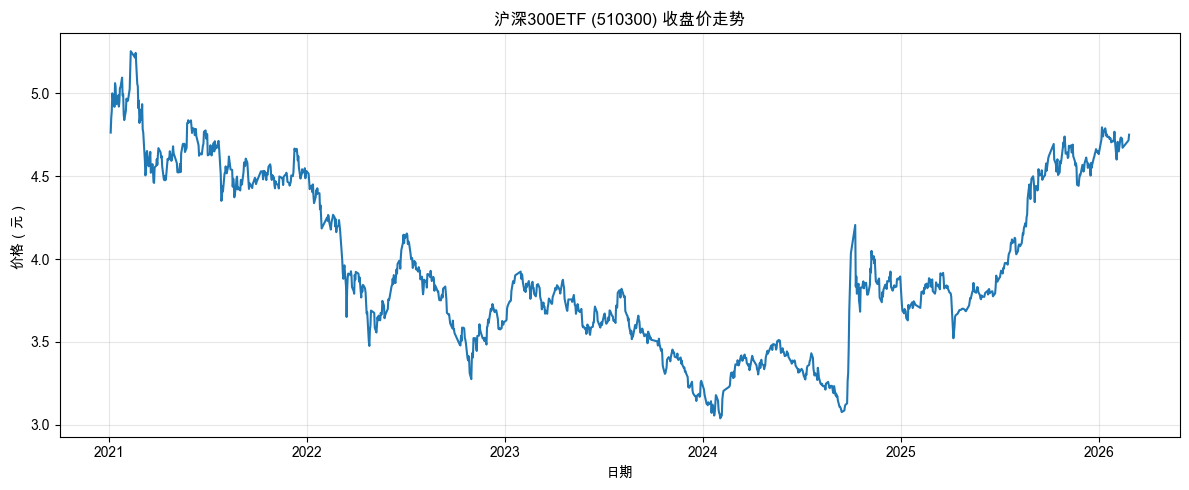

In [3]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 设置中文显示
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'SimHei', 'STHeiti']
plt.rcParams['axes.unicode_minus'] = False

# 获取沪深300ETF日线数据（最近约5年）
df = yf.download('510300.SS', start='2021-01-01', auto_adjust=True, multi_level_index=False, progress=False)

print(df.head())
print(f"\n数据范围: {df.index[0].date()} 到 {df.index[-1].date()}")
print(f"数据总行数: {len(df)}")

# 收盘价走势图
plt.figure(figsize=(12, 5))
plt.plot(df.index, df['Close'], linewidth=1.5)
plt.title('沪深300ETF (510300) 收盘价走势')
plt.xlabel('日期')
plt.ylabel('价格（元）')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Step 1 解读

你现在看到的是沪深300ETF过去5年的真实价格走势。这张图本身就在告诉你一些事情：

- 价格有涨有跌，波动是常态
- 某些时期涨势明显，某些时期持续下跌

有了这些数据，下一个问题自然就是：**如果我从5年前开始定期买入，到现在是赚了还是亏了？**

---

## Step 2: 定投回测

现在我们来实现最简单的量化策略——**定投**：每月第一个交易日，用固定金额（1000元）买入沪深300ETF。

这个策略简单到几乎不需要任何判断，但它满足「量化」的核心要求：**规则明确、可复现、可验证**。

用历史数据模拟策略执行的过程叫做**回测（Backtest）**。

👉 **打开 `specs/spec-02-dca-backtest.md`，将全部内容复制到 TRAE 的 AI 助手中。**

投资期间: 2021-01 到 2026-02
投资月数: 62
总投入: 62,000 元
最终市值: 75,402 元
最终收益率: 21.62%


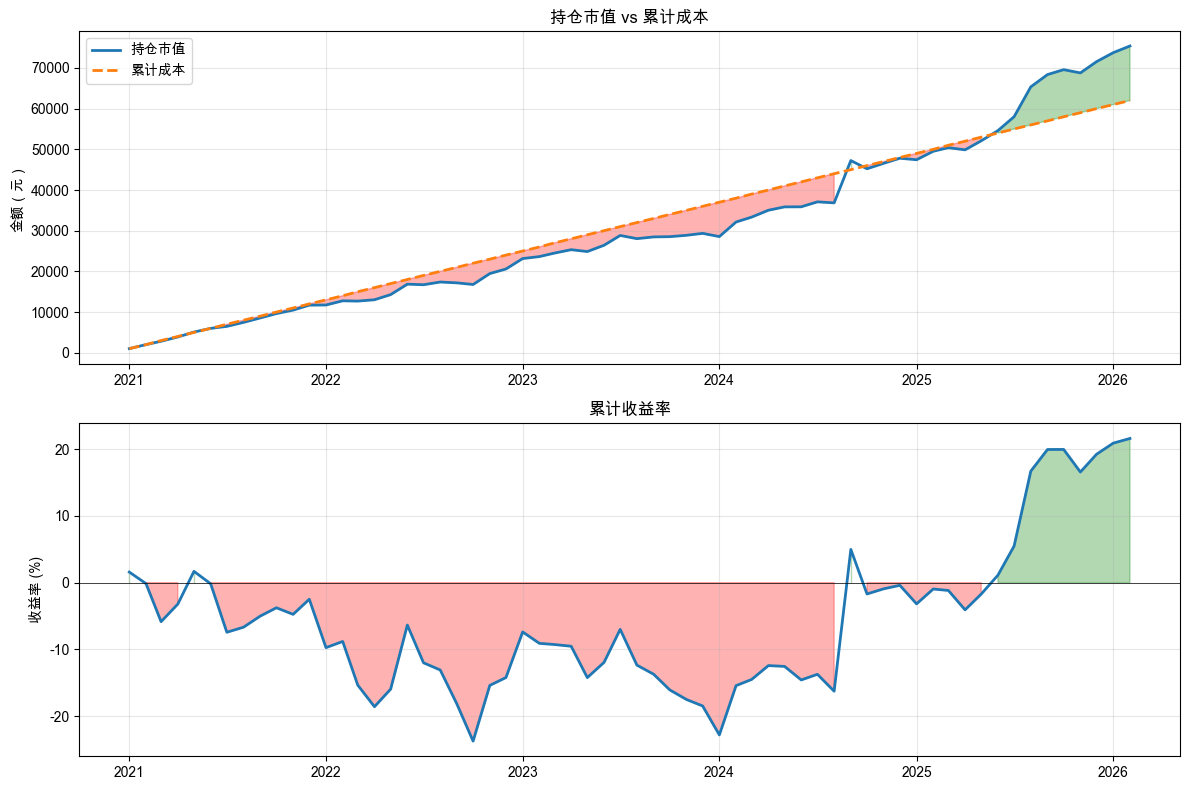

In [5]:
def backtest_dca(df, monthly_amount=1000):
    """
    定投回测 (Dollar Cost Averaging)
    """
    df = df.copy()
    df['month'] = df.index.to_period('M')

    # 每月第一个交易日买入
    monthly_first = df.groupby('month').first()
    shares_bought = monthly_amount / monthly_first['Close']
    total_shares = shares_bought.cumsum()
    total_cost = monthly_amount * np.arange(1, len(monthly_first) + 1)

    # 每月末市值
    monthly_last = df.groupby('month').last()
    portfolio_value = total_shares * monthly_last['Close']
    returns = (portfolio_value.values - total_cost) / total_cost

    result_dca = pd.DataFrame({
        'total_cost': total_cost,
        'total_shares': total_shares.values,
        'portfolio_value': portfolio_value.values,
        'return': returns
    }, index=monthly_first.index)

    return result_dca


result_dca = backtest_dca(df)

print(f"投资期间: {result_dca.index[0]} 到 {result_dca.index[-1]}")
print(f"投资月数: {len(result_dca)}")
print(f"总投入: {result_dca['total_cost'].iloc[-1]:,.0f} 元")
print(f"最终市值: {result_dca['portfolio_value'].iloc[-1]:,.0f} 元")
print(f"最终收益率: {result_dca['return'].iloc[-1]:.2%}")

# 可视化
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

ts = result_dca.index.to_timestamp()

ax1 = axes[0]
ax1.plot(ts, result_dca['portfolio_value'], label='持仓市值', linewidth=2)
ax1.plot(ts, result_dca['total_cost'], label='累计成本', linewidth=2, linestyle='--')
ax1.fill_between(ts, result_dca['total_cost'], result_dca['portfolio_value'],
                  where=result_dca['portfolio_value'] > result_dca['total_cost'],
                  alpha=0.3, color='green')
ax1.fill_between(ts, result_dca['total_cost'], result_dca['portfolio_value'],
                  where=result_dca['portfolio_value'] <= result_dca['total_cost'],
                  alpha=0.3, color='red')
ax1.set_ylabel('金额（元）')
ax1.set_title('持仓市值 vs 累计成本')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2 = axes[1]
ax2.plot(ts, result_dca['return'] * 100, linewidth=2)
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax2.fill_between(ts, 0, result_dca['return'] * 100,
                  where=result_dca['return'] > 0, alpha=0.3, color='green')
ax2.fill_between(ts, 0, result_dca['return'] * 100,
                  where=result_dca['return'] <= 0, alpha=0.3, color='red')
ax2.set_ylabel('收益率 (%)')
ax2.set_title('累计收益率')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Step 2 解读

定投5年的结果出来了。不管最终是赚是亏，有一件事是确定的：

**定投不保证赚钱，也不保证亏钱。** 它只是一种「分散买入时点」的方法，降低了择时风险，但收益仍然取决于市场整体表现。

这时候一个自然的问题出现了：**我的定投收益，应该和什么比较？** 是跑赢了市场，还是跑输了？

---

## Step 3: 和基准对比

如果你定投赚了10%，但同期市场涨了20%，你其实是「跑输」了。反过来，如果你定投亏了5%，但市场跌了15%，你反而「跑赢」了。

我们用「一次性买入持有」作为**基准（Benchmark）**来对比。

👉 **打开 `specs/spec-03-benchmark.md`，将全部内容复制到 TRAE 的 AI 助手中。**

沪深300ETF 起点价格: 4.763
沪深300ETF 终点价格: 4.750

一次性买入收益率: -0.27%
定投收益率: 21.62%
差异: 21.88%

→ 定投跑赢了一次性买入！
  在下跌市中，定投通过分批买入避开了部分高位。

但两种策略都没有 Alpha——收益完全取决于市场涨跌，这就是 Beta。


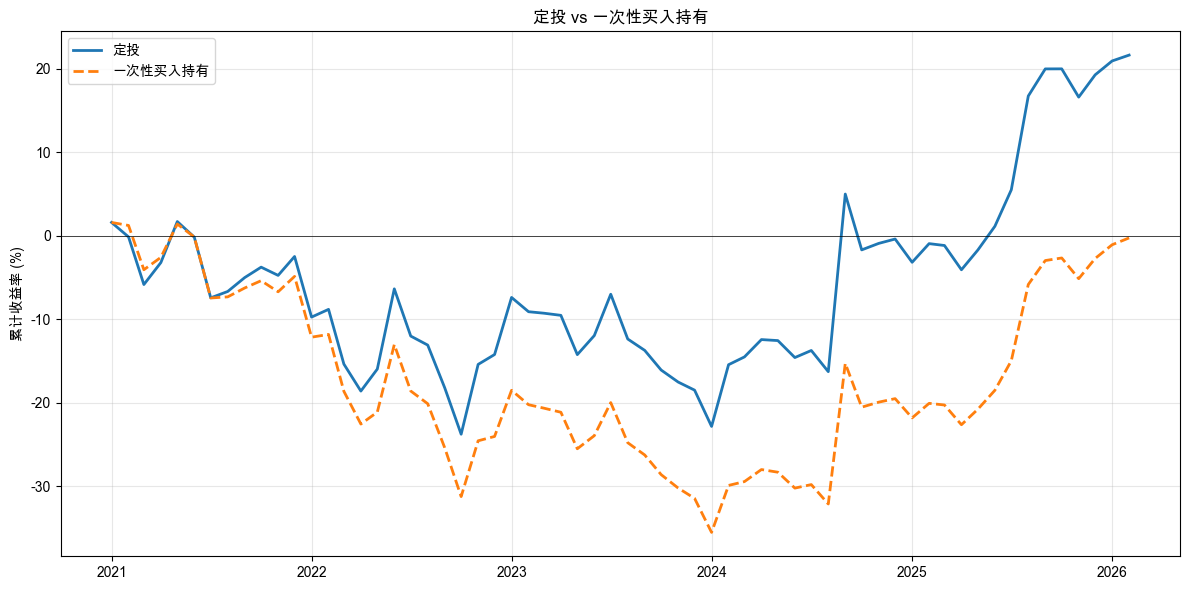

In [6]:
# 基准：一次性买入持有
initial_price = df['Close'].iloc[0]
final_price = df['Close'].iloc[-1]
benchmark_return = (final_price - initial_price) / initial_price

dca_return = result_dca['return'].iloc[-1]

print(f"沪深300ETF 起点价格: {initial_price:.3f}")
print(f"沪深300ETF 终点价格: {final_price:.3f}")
print(f"\n一次性买入收益率: {benchmark_return:.2%}")
print(f"定投收益率: {dca_return:.2%}")
print(f"差异: {dca_return - benchmark_return:.2%}")

if dca_return > benchmark_return:
    print("\n→ 定投跑赢了一次性买入！")
    print("  在下跌市中，定投通过分批买入避开了部分高位。")
else:
    print("\n→ 定投跑输了一次性买入！")
    print("  在上涨市中，越早全部投入越好。")

print("\n但两种策略都没有 Alpha——收益完全取决于市场涨跌，这就是 Beta。")

# 对比图：定投 vs 买入持有
df_monthly = df.copy()
df_monthly['month'] = df_monthly.index.to_period('M')
monthly_last = df_monthly.groupby('month').last()
bnh_monthly_return = (monthly_last['Close'].values - initial_price) / initial_price

fig, ax = plt.subplots(figsize=(12, 6))
ts = result_dca.index.to_timestamp()
ax.plot(ts, result_dca['return'] * 100, label='定投', linewidth=2)
ax.plot(ts, bnh_monthly_return * 100, label='一次性买入持有', linewidth=2, linestyle='--')
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax.set_ylabel('累计收益率 (%)')
ax.set_title('定投 vs 一次性买入持有')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Step 3 解读

这里引出了两个关键概念：

**Beta（贝塔）：市场收益**
- 你承担了市场风险，市场涨你就涨，市场跌你就跌
- 定投策略没有任何「自己的想法」，收益纯粹来自 Beta

**Alpha（阿尔法）：超额收益**
- 你比市场多赚的部分，才是策略的真本事
- Alpha 需要你做出某种「判断」，并且这个判断要比市场更聪明

那么问题来了：**怎么才能有 Alpha？**

---

## Step 4: 加入均线择时

为了获取 Alpha，我们需要加入一些「判断」。最简单的判断工具是**均线**：

- **均线**：过去 N 天收盘价的平均值
- **逻辑**：价格在均线上方 → 趋势向上 → 适合买入

新策略：每月定投日，**仅当收盘价高于 N 日均线时才买入**，否则跳过。

我们将测试三个不同的均线参数（MA10、MA20、MA60），看看哪个效果更好。

👉 **打开 `specs/spec-04-ma-timing.md`，将全部内容复制到 TRAE 的 AI 助手中。**

均线择时策略：不同参数对比
MA 10: 收益率  19.94%, 买入 32/62 次
MA 20: 收益率  18.91%, 买入 25/62 次
MA 60: 收益率  18.49%, 买入 27/62 次

简单定投: 收益率 21.62%


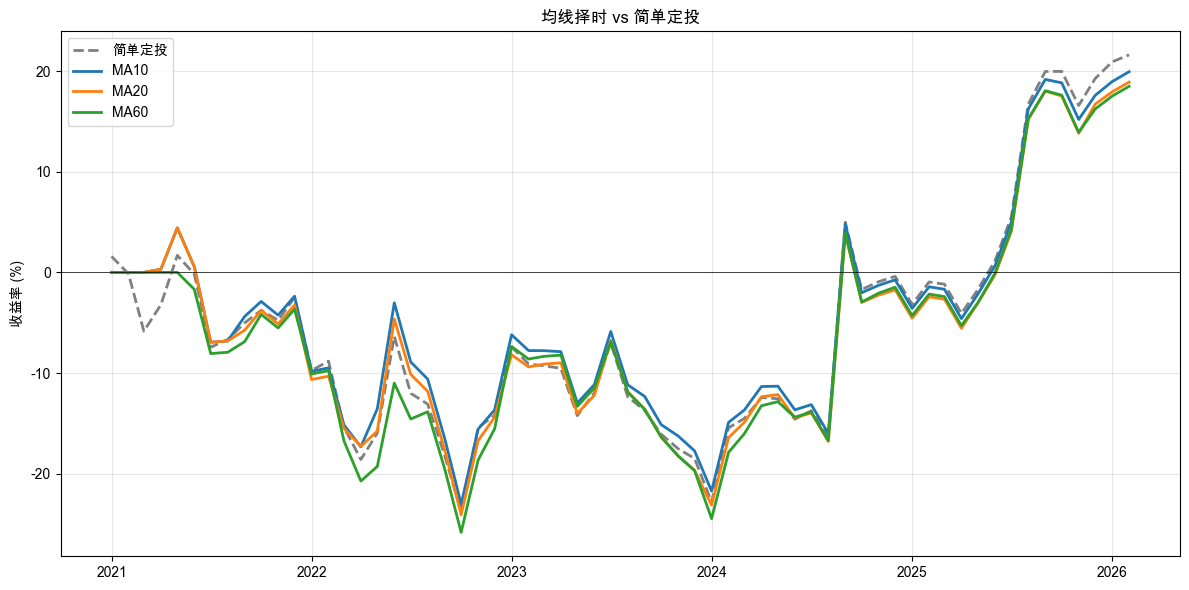

In [7]:
def backtest_dca_with_ma(df, monthly_amount=1000, ma_period=20):
    """
    带均线条件的定投回测
    规则：每月第一个交易日，如果收盘价 > N日均线，则买入；否则跳过
    """
    df = df.copy()
    df['ma'] = df['Close'].rolling(ma_period).mean()
    df['month'] = df.index.to_period('M')
    monthly_first = df.groupby('month').first()
    monthly_first['signal'] = monthly_first['Close'] > monthly_first['ma']

    shares_list, cost_list = [], []
    total_shares, total_cost = 0, 0

    for idx, row in monthly_first.iterrows():
        if pd.notna(row['ma']) and row['signal']:
            total_shares += monthly_amount / row['Close']
            total_cost += monthly_amount
        shares_list.append(total_shares)
        cost_list.append(total_cost)

    monthly_last = df.groupby('month').last()
    portfolio_value = np.array(shares_list) * monthly_last['Close'].values
    cost_array = np.array(cost_list)
    returns = np.zeros(len(cost_array))
    mask = cost_array > 0
    returns[mask] = (portfolio_value[mask] - cost_array[mask]) / cost_array[mask]

    return pd.DataFrame({
        'total_cost': cost_list,
        'total_shares': shares_list,
        'portfolio_value': portfolio_value,
        'return': returns,
        'signal': monthly_first['signal'].values
    }, index=monthly_first.index)


# 对比不同均线参数
print("均线择时策略：不同参数对比")
print("=" * 45)

ma_results = {}
for ma in [10, 20, 60]:
    result = backtest_dca_with_ma(df, ma_period=ma)
    ma_results[f'MA{ma}'] = result
    buy_count = int(result['signal'].sum())
    total_months = len(result)
    print(f"MA{ma:3d}: 收益率 {result['return'].iloc[-1]:7.2%}, 买入 {buy_count:2d}/{total_months} 次")

print(f"\n简单定投: 收益率 {result_dca['return'].iloc[-1]:.2%}")

# 对比图
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(result_dca.index.to_timestamp(), result_dca['return'] * 100,
        label='简单定投', linewidth=2, linestyle='--', color='gray')
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
for (name, result), color in zip(ma_results.items(), colors):
    ax.plot(result.index.to_timestamp(), result['return'] * 100,
            label=name, linewidth=2, color=color)
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax.set_ylabel('收益率 (%)')
ax.set_title('均线择时 vs 简单定投')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Step 4 解读

对比结果出来了。注意看每个均线参数的收益率和买入次数——加入均线条件后，策略会跳过部分月份的买入。

不同参数效果不同，这自然会让你产生一个冲动：**最好的参数到底是多少？能不能穷举所有可能，找到那个最优的？**

这个想法很自然，但也很危险。让我们试试看。

---

## Step 5: 参数扫描

我们来做一件看起来很「科学」的事情：穷举 MA5 到 MA120 所有参数，找到收益率最高的那个。

👉 **打开 `specs/spec-05-param-scan.md`，将全部内容复制到 TRAE 的 AI 助手中。**

最优参数: MA5
最优收益率: 22.73%
简单定投收益率: 21.62%
收益提升: 1.12%


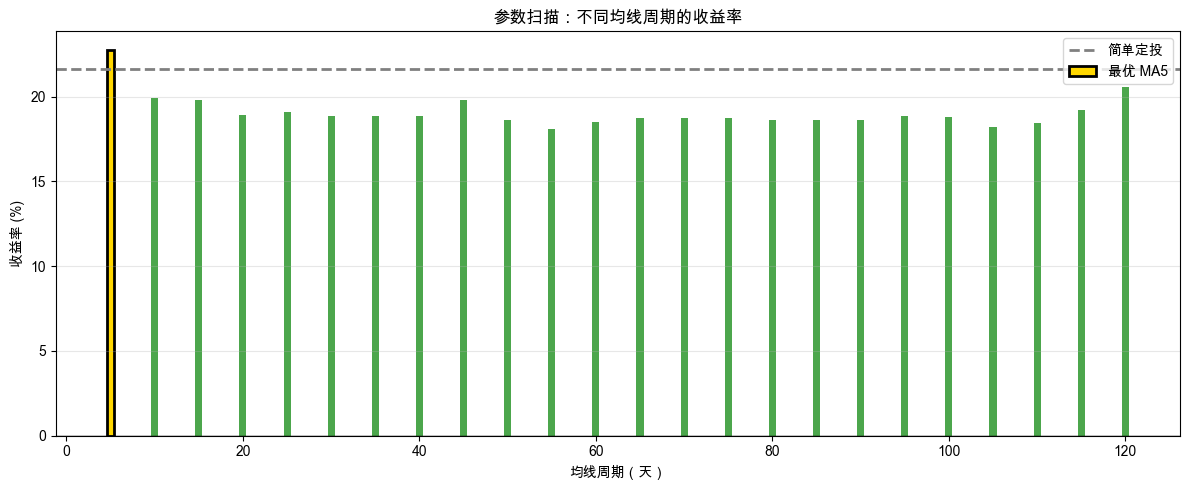

In [8]:
# 参数扫描
scan_results = []
for ma in range(5, 121, 5):
    result = backtest_dca_with_ma(df, ma_period=ma)
    scan_results.append({'ma_period': ma, 'return': result['return'].iloc[-1]})

scan_df = pd.DataFrame(scan_results)
best = scan_df.loc[scan_df['return'].idxmax()]

print(f"最优参数: MA{int(best['ma_period'])}")
print(f"最优收益率: {best['return']:.2%}")
print(f"简单定投收益率: {result_dca['return'].iloc[-1]:.2%}")
print(f"收益提升: {best['return'] - result_dca['return'].iloc[-1]:.2%}")

# 柱状图
fig, ax = plt.subplots(figsize=(12, 5))
colors = ['green' if r > 0 else 'red' for r in scan_df['return']]
ax.bar(scan_df['ma_period'], scan_df['return'] * 100, color=colors, alpha=0.7)
ax.bar(best['ma_period'], best['return'] * 100, color='gold', edgecolor='black', linewidth=2,
       label=f"最优 MA{int(best['ma_period'])}")
ax.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax.axhline(y=result_dca['return'].iloc[-1] * 100, color='gray', linestyle='--', linewidth=2,
           label='简单定投')
ax.set_xlabel('均线周期（天）')
ax.set_ylabel('收益率 (%)')
ax.set_title('参数扫描：不同均线周期的收益率')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

### Step 5 解读

你找到了一个收益率很漂亮的「最优参数」！从简单定投的负收益变成了正收益，看起来像是发现了一个赚钱的秘诀。

**但这真的可靠吗？**

想一想：你测试了 24 个参数，总有一个碰巧在这段时间表现最好。这就像射箭——先射出去，再在箭落的地方画靶心，当然百发百中。

要验证这个参数是否真的有效，我们需要一个公平的测试：**用一段从未见过的数据来检验它。**

---

## Step 6: 样本外测试——真相时刻

我们把数据分成两段：
- **训练集**（前 60%）：用来找最优参数
- **测试集**（后 40%）：用来验证这个参数在「未来」是否有效

这就像考试——你不能用试卷上的题目来复习，那样的好成绩毫无意义。

👉 **打开 `specs/spec-06-overfitting.md`，将全部内容复制到 TRAE 的 AI 助手中。**

In [9]:
# 样本外测试
split_idx = int(len(df) * 0.6)
split_date = df.index[split_idx]
train = df.loc[:split_date]
test = df.loc[split_date:]

print(f"训练集: {train.index[0].date()} 到 {train.index[-1].date()} ({len(train)} 条)")
print(f"测试集: {test.index[0].date()} 到 {test.index[-1].date()} ({len(test)} 条)")

# 训练集上找最优参数
train_scan = []
for ma in range(5, 121, 5):
    result = backtest_dca_with_ma(train, ma_period=ma)
    train_scan.append({'ma': ma, 'return': result['return'].iloc[-1]})
train_scan_df = pd.DataFrame(train_scan)
best_ma = int(train_scan_df.loc[train_scan_df['return'].idxmax()]['ma'])
best_train_return = train_scan_df['return'].max()

# 测试集上验证
test_ma_result = backtest_dca_with_ma(test, ma_period=best_ma)
test_ma_return = test_ma_result['return'].iloc[-1]

test_simple_result = backtest_dca(test)
test_simple_return = test_simple_result['return'].iloc[-1]

print(f"\n训练集最优: MA{best_ma}, 收益率 {best_train_return:.2%}")
print(f"测试集表现: MA{best_ma}, 收益率 {test_ma_return:.2%}")
print(f"测试集简单定投: 收益率 {test_simple_return:.2%}")

print("\n" + "=" * 50)
if test_ma_return < test_simple_return:
    print("这就是过拟合——你在历史数据上找到的是巧合，不是规律。")
else:
    print("结果看起来还行，但仍需谨慎，样本量有限。")
print("=" * 50)

训练集: 2021-01-04 到 2024-01-26 (746 条)
测试集: 2024-01-26 到 2026-02-25 (498 条)

训练集最优: MA5, 收益率 -18.24%
测试集表现: MA5, 收益率 23.28%
测试集简单定投: 收益率 25.91%

这就是过拟合——你在历史数据上找到的是巧合，不是规律。


### Step 6 解读

**真相揭晓：** 在训练集上表现最好的参数，在测试集上很可能表现平平，甚至比最简单的定投还差。

这就是**过拟合（Overfitting）**——量化交易最大的敌人。

你找到的不是「规律」，而是「巧合」。原因有三：
1. **数据挖掘偏差**：测试了24个参数，总有一个碰巧表现好
2. **市场结构变化**：前几年和后几年的市场特征不同
3. **参数缺乏经济含义**：一个精确到个位数的均线周期，不可能有真实的经济逻辑支撑

---

## 本章总结

### 核心概念

| 概念 | 含义 |
|------|------|
| **回测 (Backtest)** | 用历史数据模拟策略执行 |
| **基准 (Benchmark)** | 用来比较的参照物（如买入持有） |
| **Beta（贝塔）** | 承担市场风险获得的收益——市场涨你涨 |
| **Alpha（阿尔法）** | 超越市场的收益——策略的真本事 |
| **过拟合 (Overfitting)** | 把噪音当成规律，历史好看未来不灵 |

### 策略进化路径

| 版本 | 策略 | 教训 |
|------|------|------|
| v0.1 | 简单定投 | 纯 Beta 暴露，收益随市场波动 |
| v0.2 | 定投 + 均线择时 | 加入判断尝试获取 Alpha |
| v0.3 | 参数扫描优化 | 掉入过拟合陷阱 |

### 带走的问题

学完这一章，你应该有这些问题在脑海中挥之不去：

- **怎么区分运气和能力？** → Q5、Q6 会解答
- **有没有不容易过拟合的策略？** → Q4、Q6 会解答
- **怎么知道策略在未来还能赚钱？** → Q5 会解答
- **只买一个 ETF 够吗？应该买什么？** → Q2 会解答

这些问题将驱动你的后续学习。